In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [62]:
df = pd.read_csv('AEP_hourly.csv.zip', index_col = 0,parse_dates=[0])

In [63]:
start_date = str(df.index.min())
end_date = str(df.index.max())
print ('This hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This hourly power consumption dataset ranges from 2004-10-01 01:00:00 to 2018-08-03 00:00:00.


In [172]:
df = df.sort_index()
df_sub = df.loc[pd.Timestamp('2005-01-01'):pd.Timestamp('2017-12-31')]
start_date = str(df_sub.index.min())
end_date = str(df_sub.index.max())
print ('This new hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This new hourly power consumption dataset ranges from 2005-01-01 00:00:00 to 2017-12-31 00:00:00.


In [173]:
df_sub.sort_index().head()

,AEP_MW
Datetime,
2005-01-01 00:00:00,12892.0
2005-01-01 01:00:00,12316.0
2005-01-01 02:00:00,11890.0
2005-01-01 03:00:00,11579.0
2005-01-01 04:00:00,11461.0


#### Transform hourly data into daily data

In [174]:
#df_by_day = df.groupby(df.index.to_period('D')).mean()
df_by_mon = df_sub.groupby(df_sub.index.to_period('M')).mean()

In [175]:
df_by_mon.head()

,AEP_MW
Datetime,
2005-01,17117.088710
2005-02,16496.644345
2005-03,15924.061828
2005-04,14032.422809
2005-05,13685.072581


In [176]:
print (df_by_mon.describe())

             AEP_MW
count    156.000000
mean   15519.146958
std     1482.159194
min    12805.127688
25%    14356.824762
50%    15330.416187
75%    16704.216062
max    19212.903274


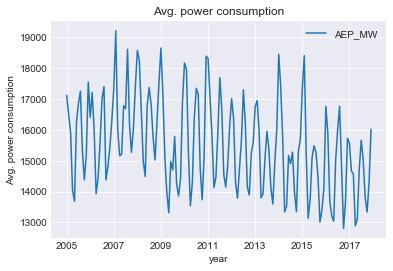

In [177]:
sns.set_style('darkgrid')
df_by_mon.plot()
plt.xlabel('year')
plt.ylabel('Avg. power consumption')
plt.title('Avg. power consumption')
plt.show()

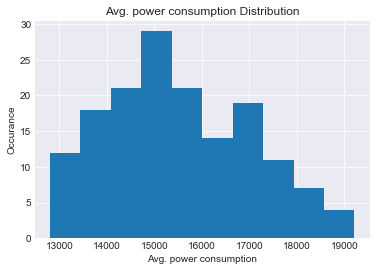

Right skewed --- outliers existed


In [178]:
df_by_mon.hist()
plt.xlabel('Avg. power consumption')
plt.ylabel('Occurance')
plt.title('Avg. power consumption Distribution')
plt.show()
print ('Right skewed --- outliers existed')

C:\Users\May Xiao\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1421: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


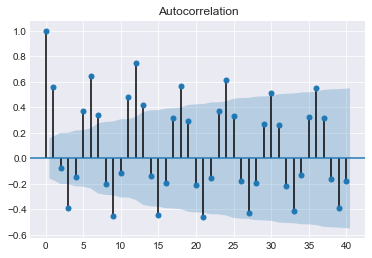

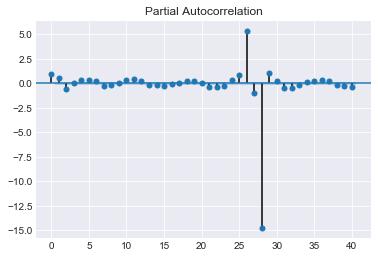

ACF is decaying slowly, which means this Time Series is very likely non-stationary.


In [179]:
plot_acf(df_by_mon['AEP_MW'].values, lags=40)
plot_pacf(df_by_mon['AEP_MW'].values, lags=40)
plt.show()
print('ACF is decaying slowly, which means this Time Series is very likely non-stationary.')

In [180]:
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

check_adfuller(df_by_mon['AEP_MW'])

Test statistic:  -1.4255120540223842
p-value:  0.5699860661149482
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}


#### We use statistic to verify: Test statistic is less than critial value and P value is greater than 0.05, so we can say this is a non-stationary Time series. Since the Times series seems to have seasonal peaks and trends, we can decompose it into level, trend, seasonality and noise components. 

In [182]:
df_by_mon.interpolate(inplace = True)
df_by_mon.index=df_by_mon.index.to_timestamp()

Residual are around 0 with constant variance, so we can be sure there are seasonality and trend patterns in this time series.


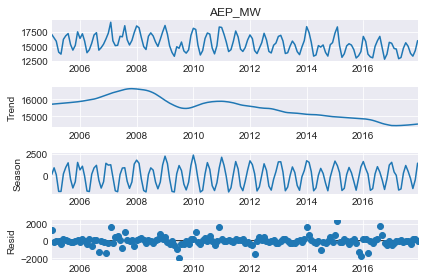

In [203]:
stl = STL(df_by_mon['AEP_MW'], period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
print('Residual are around 0 with constant variance, so we can be sure there\
 are seasonality and trend patterns in this time series.')

In [234]:
from statsmodels.tsa.api import ExponentialSmoothing

In [241]:
ets_stl = ExponentialSmoothing((df_by_mon['AEP_MW']) ,seasonal_periods=6 ,trend='add', seasonal='add').fit()
ets_stl1 = ets_stl.forecast(len(df_by_mon['AEP_MW']))

C:\Users\May Xiao\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:1096: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\May Xiao\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:1102: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


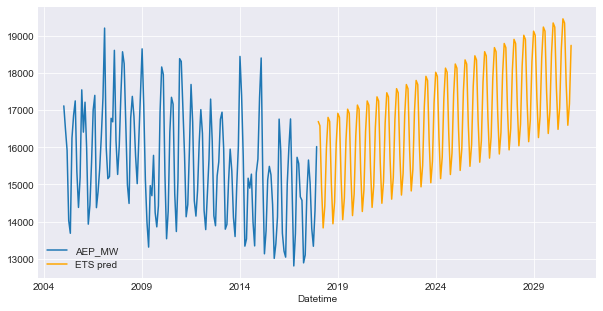

In [242]:
df_by_mon['AEP_MW'].plot(kind="line",figsize=(10,5),legend=True)
ets_stl1.plot(kind="line",figsize=(10,5),color='orange',legend=True,label='ETS pred')

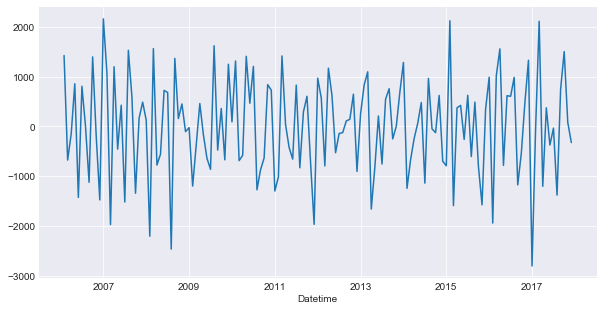

In [276]:
from statsmodels.tsa.arima_model import ARIMA
 
time_log_diff = time_sea_diff - time_sea_diff.shift()
time_log_diff.plot(kind="line",figsize=(10,5))

In [277]:
time_log_diff = time_log_diff.dropna()
check_adfuller(time_log_diff)

Test statistic:  -4.132082004909603
p-value:  0.0008567905778000824
Critical Values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}


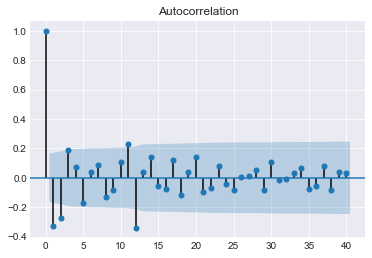

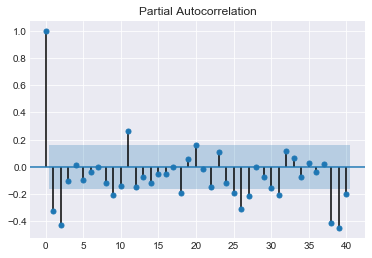

In [278]:
plot_acf(time_log_diff, lags=40)
plot_pacf(time_log_diff, lags=40)
plt.show()

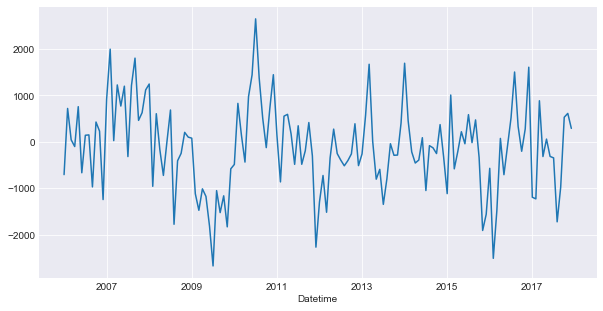

In [273]:
time_sea_diff = df_by_mon['AEP_MW'] - df_by_mon['AEP_MW'].shift(12)
time_sea_diff.plot(kind="line",figsize=(10,5))

In [274]:
time_sea_diff = time_sea_diff.dropna()
check_adfuller(time_sea_diff)

Test statistic:  -3.9348300783889076
p-value:  0.001792956397610151
Critical Values: {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}


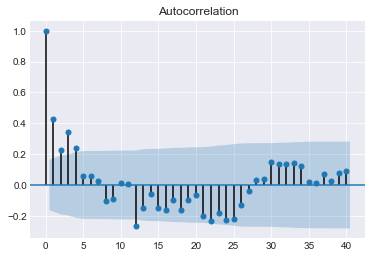

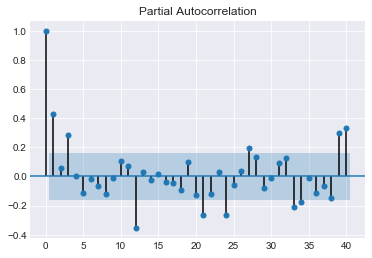

In [275]:
plot_acf(time_sea_diff, lags=40)
plot_pacf(time_sea_diff, lags=40)
plt.show()

In [284]:
   class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [285]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(time_sea_diff, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.934830
P-Value                   0.001793
# Lags Used              11.000000
# Observations Used     132.000000
Critical Value (1%)      -3.480888
Critical Value (5%)      -2.883697
Critical Value (10%)     -2.578586
dtype: float64
Is the time series stationary? True


### Train-Test Split

In [184]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)

Observations: 30
Training Observations: 16
Testing Observations: 14
Observations: 44
Training Observations: 30
Testing Observations: 14
Observations: 58
Training Observations: 44
Testing Observations: 14
Observations: 72
Training Observations: 58
Testing Observations: 14
Observations: 86
Training Observations: 72
Testing Observations: 14
Observations: 100
Training Observations: 86
Testing Observations: 14
Observations: 114
Training Observations: 100
Testing Observations: 14
Observations: 128
Training Observations: 114
Testing Observations: 14
Observations: 142
Training Observations: 128
Testing Observations: 14
Observations: 156
Training Observations: 142
Testing Observations: 14


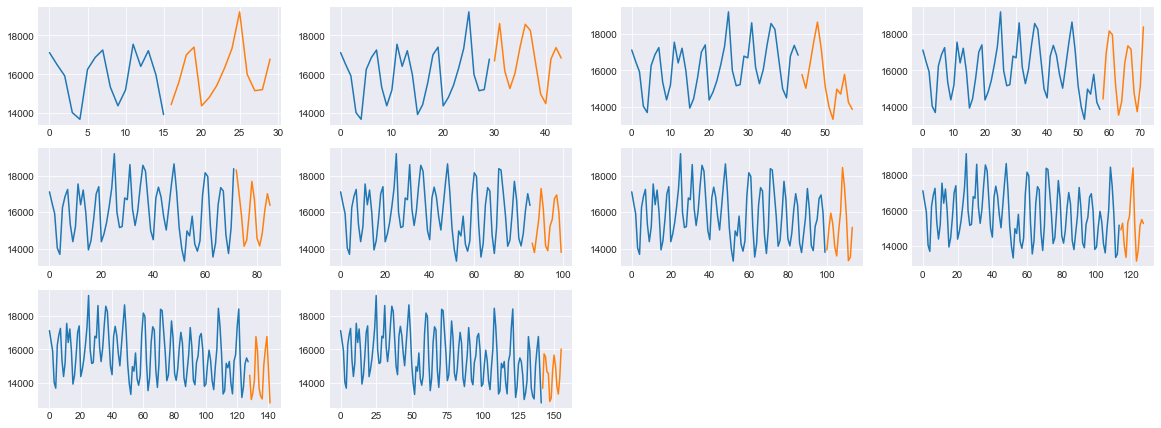

In [185]:
X = df_by_mon['AEP_MW'].values
index = 1
fig = plt.figure(figsize=(20, 10))
for train_index, test_index in cv.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(4,4, index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

### Modeling

In [218]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [219]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [220]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=6):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=10) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [225]:
%%time
data = df_by_mon['AEP_MW'][:-12] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 12 months
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 12, scaling_factor = 3)
model.triple_exponential_smoothing()

0.1759868461252208 0.03310877470056056 0.2978116011909236
Wall time: 4.16 s


In [229]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-12, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

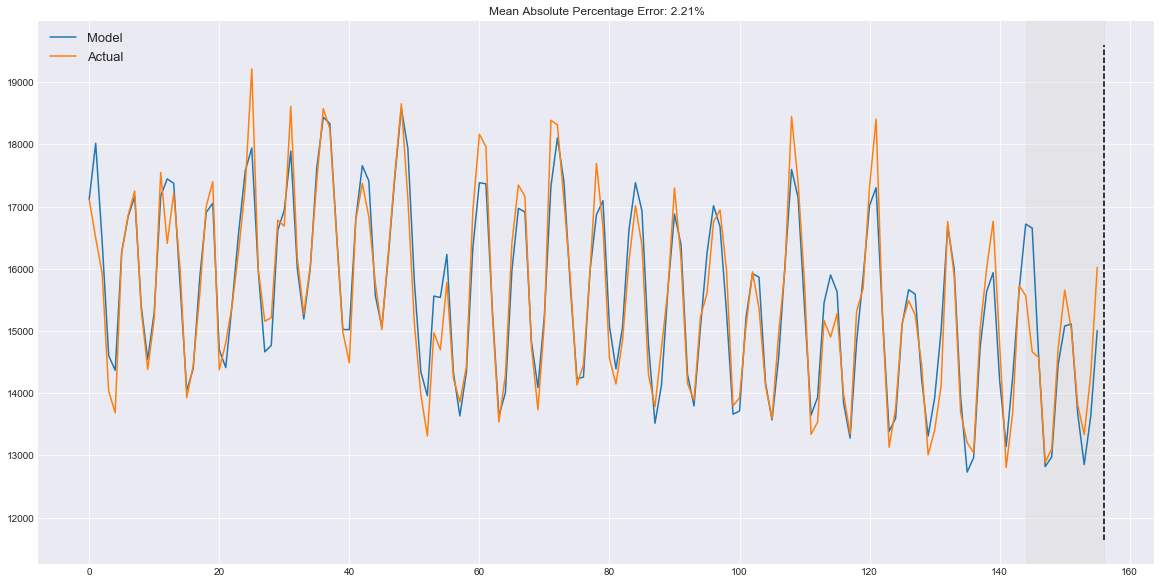

In [230]:
plotHoltWinters(df_by_mon['AEP_MW'])

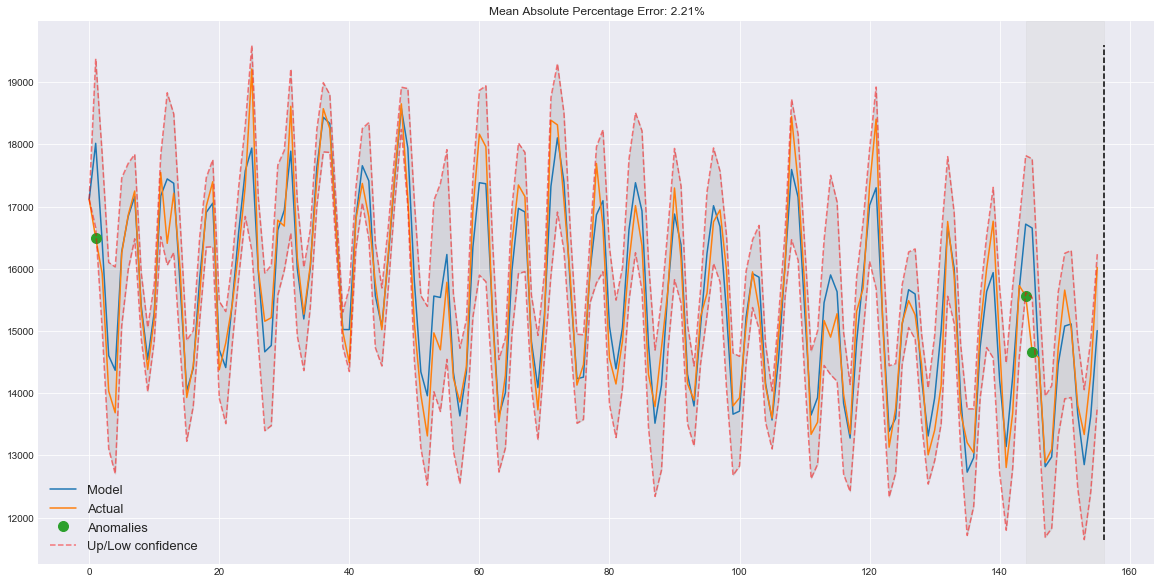

In [231]:
plotHoltWinters(df_by_mon['AEP_MW'], plot_intervals=True, plot_anomalies=True)